# Face Recognition using Principal Component Analysis

- To create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

- The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

- Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

- The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

%matplotlib inline


#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [3]:
image_width= 0
image_height= 0

In [4]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """
    global image_height
    global image_width
    
    total_images = int(X.shape[0])
    image_width = int(X.shape[1])
    image_height = int(X.shape[2])

    flattern_image_data_set = []
    
    for image in X:
        flattern_image = [element for sublist in image for element in sublist]
        flattern_image_data_set.append(flattern_image)
    
    '''
        - flatternning the the dataset to 1d vector
        - substracting the mean of the dataset from the dataset.
    '''
    flattern_image_data_set = np.array(flattern_image_data_set)

    flattern_image_data_set = flattern_image_data_set - np.mean(flattern_image_data_set, axis=0)

    # std_dev =  np.std(flattern_image_data_set , axis=0)    
    # column_standarised_dataset = (flattern_image_data_set - mean)  / std_dev


    '''
        finding the covarience matrix of DxD size for finding the eigen vector of flattern dataset
    '''
    covarience_matrix = np.cov(flattern_image_data_set, rowvar=False) 
    # covarience_matrix = covarience_matrix / total_images


    '''
        - finding the eigen value and eigen vector from covarience matrix of DxD size
        - it return max d eigen value and and corresponding eigen vector
        - these eigen values are not sorted so sorting it and keep the track of indices and arrange the eigen value and eigen vector according to it by max value indices which obtain by argmax
    '''
    eigen_values , eigen_vectors = np.linalg.eig(covarience_matrix)

    sorted_indices = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_indices]
    eigen_vectors = eigen_vectors[:, sorted_indices]


    '''
        - finding the vairence for each eigen value 
        - varience of eigen value represent particular eigen value and corresponding the eigen vector how much they preserved the data  of the original data
    '''

    total_varience = np.sum(eigen_values)
    varience = np.sum(eigen_values)

    preserved_varience = varience / total_varience
    

    '''
        - eigen value and vector are might be complex so converting to real value so we can visulase by matplotlib
        - converting all eigen vector to unit eigen vector
    '''
    eigen_values =  np.real(eigen_values)
    eigen_vectors = np.real(eigen_vectors)

    eigen_vectors = eigen_vectors / np.linalg.norm(eigen_vectors, axis=0)


    '''
        - returning the all eigen value and eigen vector and its varience 
        - not returning the first n component wheneve it needed i used slicing of the array 
        - finding eigen vector everytime it become more costly so slicing will better and time saving approach
    '''

    return eigen_values ,eigen_vectors  ,preserved_varience

In [5]:
eigen_values , eigen_faces ,_ = principalComponentAnalysis(trainFaces , 5)
eigen_faces.shape

(10304, 10304)

In [6]:
eigen_faces_1 = eigen_faces[:, :5]
eigen_faces_1.shape

(10304, 5)

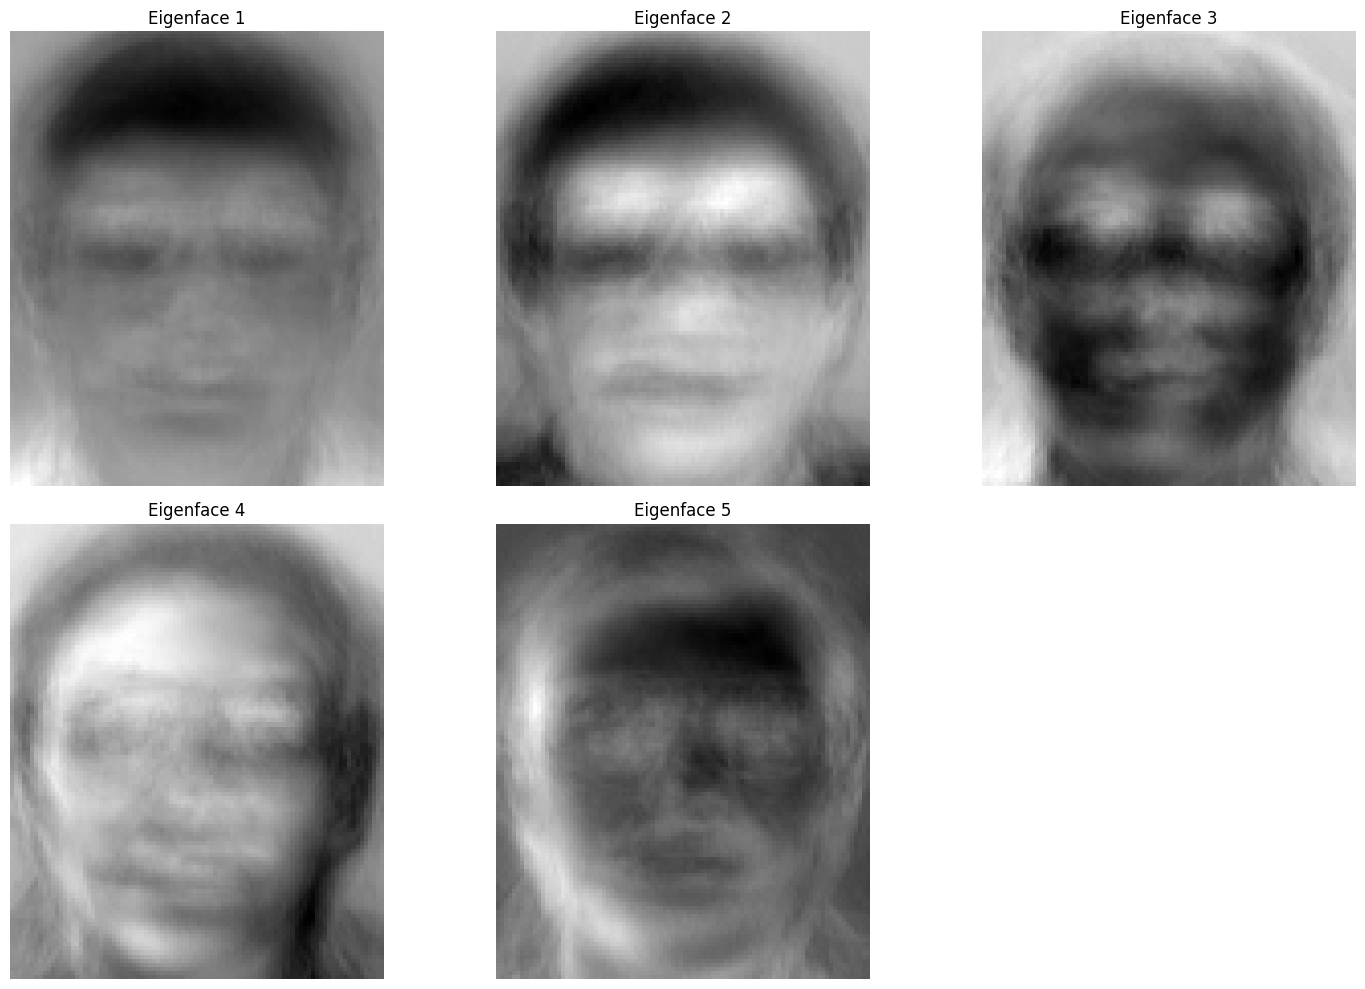

In [7]:
reshaped_eigen_faces = eigen_faces_1.T.reshape((-1, image_width, image_height))
reshaped_eigen_faces = np.real(reshaped_eigen_faces)
# plot the eigen faces
num_images_per_row = 3
num_images = len(reshaped_eigen_faces)
num_rows = (num_images + num_images_per_row - 1) // num_images_per_row

plt.figure(figsize=(15, 5 * num_rows))

for i, eigen_face in enumerate(reshaped_eigen_faces, 1):
    plt.subplot(num_rows, num_images_per_row, i)
    plt.imshow(eigen_face, cmap='gray')
    plt.title(f'Eigenface {i}') 
    plt.axis('off')

plt.tight_layout()
plt.show()



#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [8]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """

    # testFace = testFace - meanFace

    '''
        1. finding the new projected faces( D' dimenstion) by projecting over the eigen faces ( convert face D dimension to D' dimension)
        2. now reconstructing the face from the new_face (D' dimension) ( convert back D' Dimentsion to D dimension)

        - Doing this for checking when we do dimension reduction then how much information is prevesed in the new D' dimension data.
        - By comparing the original image and recontructed image we can how much image is changed
        
        3. adding the mean face to traced back to orignial image
    '''

    new_faces = np.dot(testFace , eigenFaces)   
    # print("==================================")
    # print(new_faces.shape)
    # print(testFace.shape)
    # print(eigenFaces.shape)
    reconstructed_faces = np.dot(new_faces , eigenFaces.T)
    # print(reconstructed_faces.shape)
    reconstructed_faces = reconstructed_faces + meanFace
    reconstructed_faces = reconstructed_faces.reshape(-1,112,92)
    reconstructed_faces = np.real(reconstructed_faces)

    return reconstructed_faces

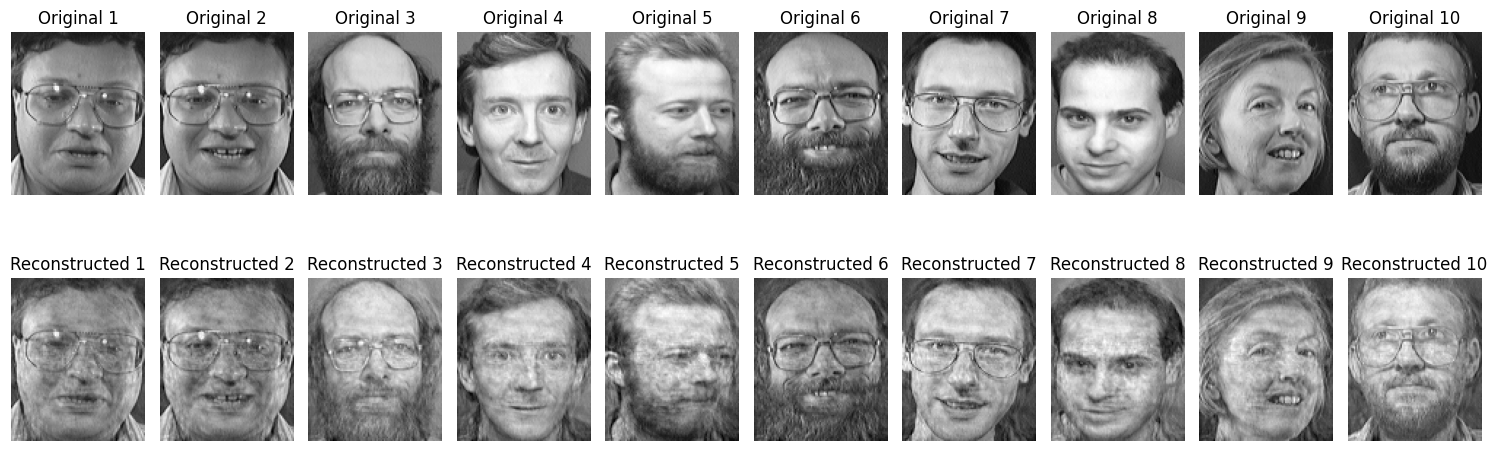

In [9]:
sample_data = trainFaces[:10]
# _ , _, eigen_faces, _ = principalComponentAnalysis(trainFaces , 200)
eigen_faces2 = eigen_faces[:,:300]
# sample_data = sample_data - np.mean(sample_data)
flattern_image_data_set = []
    
for image in sample_data:
    flattern_image = [element for sublist in image for element in sublist]
    flattern_image_data_set.append(flattern_image)

flattern_image_data_set = np.array(flattern_image_data_set)

Reconstructed_face = imageReconstruction(flattern_image_data_set , eigen_faces2 , np.mean(sample_data))


num_images_per_row = 10
num_rows = 4  

plt.figure(figsize=(15, 10))

for i, sample_data in enumerate(sample_data[:10], 1):
    plt.subplot(num_rows, num_images_per_row, i)
    plt.imshow(sample_data, cmap='gray')
    plt.title(f'Original {i}')  
    plt.axis('off') 
    
for i, Reconstructed_face in enumerate(Reconstructed_face[:10], 1):
    # Reconstructed_face = Reconstructed_face.reshape(image_width, image_height)
    plt.subplot(num_rows, num_images_per_row, i + 10)
    plt.imshow(Reconstructed_face, cmap='gray')
    plt.title(f'Reconstructed {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()



#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [10]:
def visualisation(trainFaces , number_of_componenet):

    eigen_faces1 = eigen_faces[:, :number_of_componenet]
    eigen_values1 = eigen_values[:number_of_componenet]

    total_sum = np.sum(eigen_values)
    vairence_preseved = np.sum(eigen_values1)
    vairence = vairence_preseved / total_sum

    sample_data = trainFaces[:10]
    sample_data = sample_data - np.mean(sample_data)

    flattern_image_data_set = []
        
    for image in sample_data:
        flattern_image = [element for sublist in image for element in sublist]
        flattern_image_data_set.append(flattern_image)

    flattern_image_data_set = np.array(flattern_image_data_set)

    Reconstructed_face = imageReconstruction(flattern_image_data_set , eigen_faces1 , np.mean(sample_data))


    num_images_per_row = 10
    num_rows = 4  

    print(f'\n\n\n-------------------------------The number of PC  = {number_of_componenet}-----------------------------------')
    print(f'-------------------------------With information preserved = {round(vairence*100 , 3)} % -------------------------------')
    plt.figure(figsize=(15, 10))

    for i, sample_data in enumerate(sample_data[:10], 1):
        plt.subplot(num_rows, num_images_per_row, i)
        plt.imshow(sample_data, cmap='gray')
        plt.title(f'Original {i}')  
        plt.axis('off') 
        
    for i, Reconstructed_face in enumerate(Reconstructed_face[:10], 1):
        Reconstructed_face = Reconstructed_face.reshape(image_width, image_height)
        plt.subplot(num_rows, num_images_per_row, i + 10)
        plt.imshow(Reconstructed_face, cmap='gray')
        plt.title(f'Reconstructed {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return vairence

In [11]:
%matplotlib inline

def displayNfactors():

    number_of_pc = [5,10,30,50,70,100,150,200,250,300,350,400,450,500]
    information_preserved = []

    for pc in number_of_pc:
        information_preserved.append(visualisation(trainFaces , pc)*100)
    
    plt.plot(number_of_pc, information_preserved, marker='o', linestyle='-', color='b')
    plt.title('Principle Component vs information preseved by PC')
    plt.xlabel('Principle Component')
    plt.ylabel('Percenteage of Information preserved')
    plt.grid(True)
    plt.show()

    print("\n====================================================================================================\n\n")





-------------------------------The number of PC  = 5-----------------------------------
-------------------------------With information preserved = 48.758 % -------------------------------


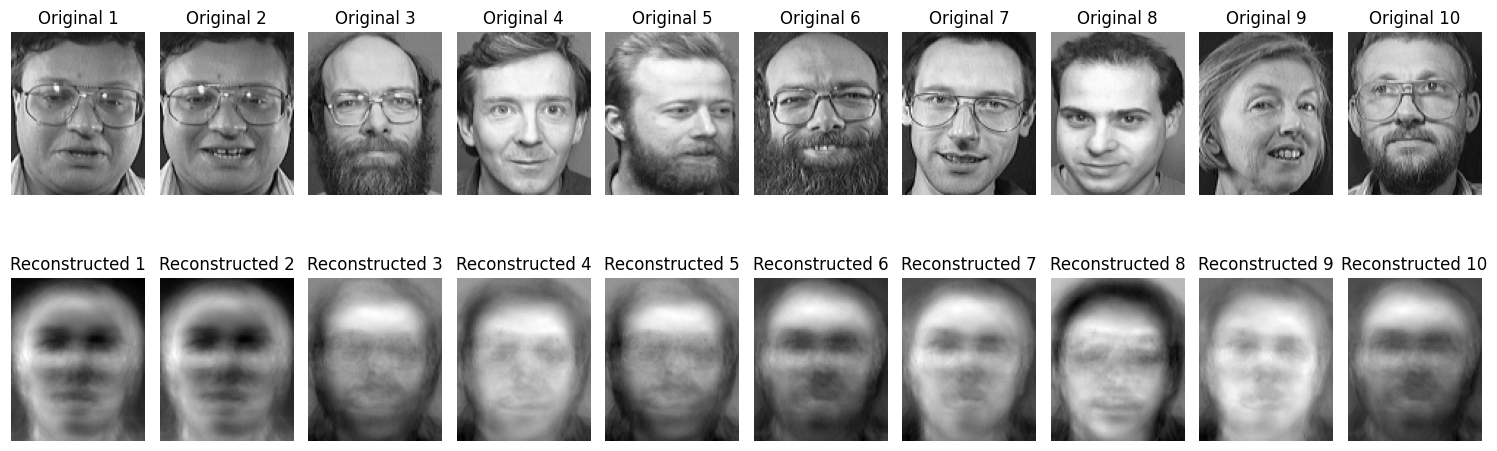




-------------------------------The number of PC  = 10-----------------------------------
-------------------------------With information preserved = 60.408 % -------------------------------


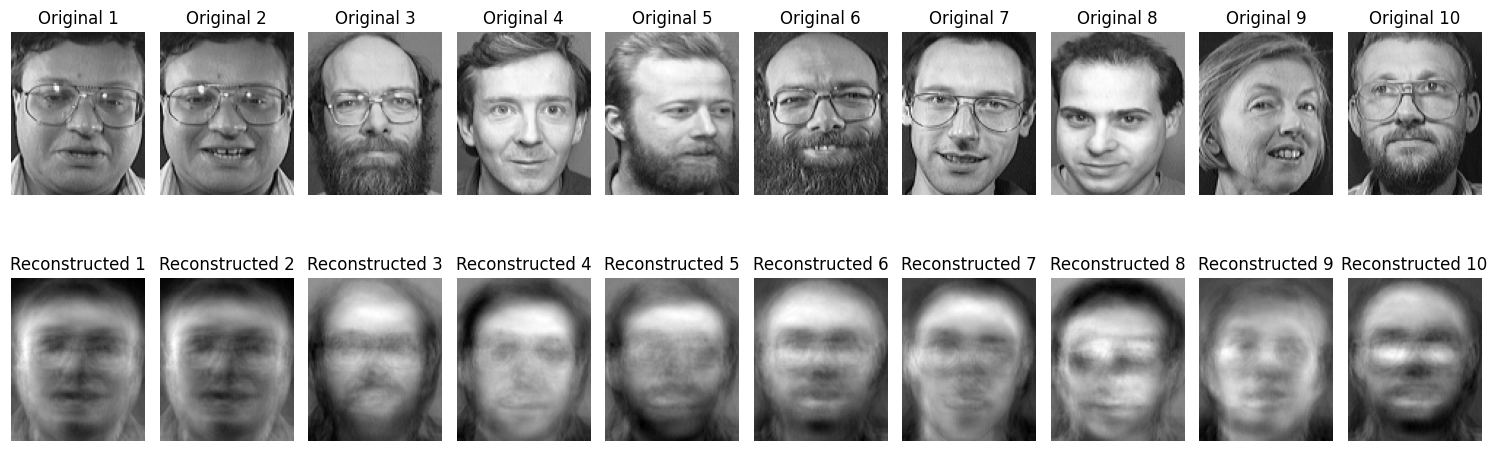




-------------------------------The number of PC  = 30-----------------------------------
-------------------------------With information preserved = 75.699 % -------------------------------


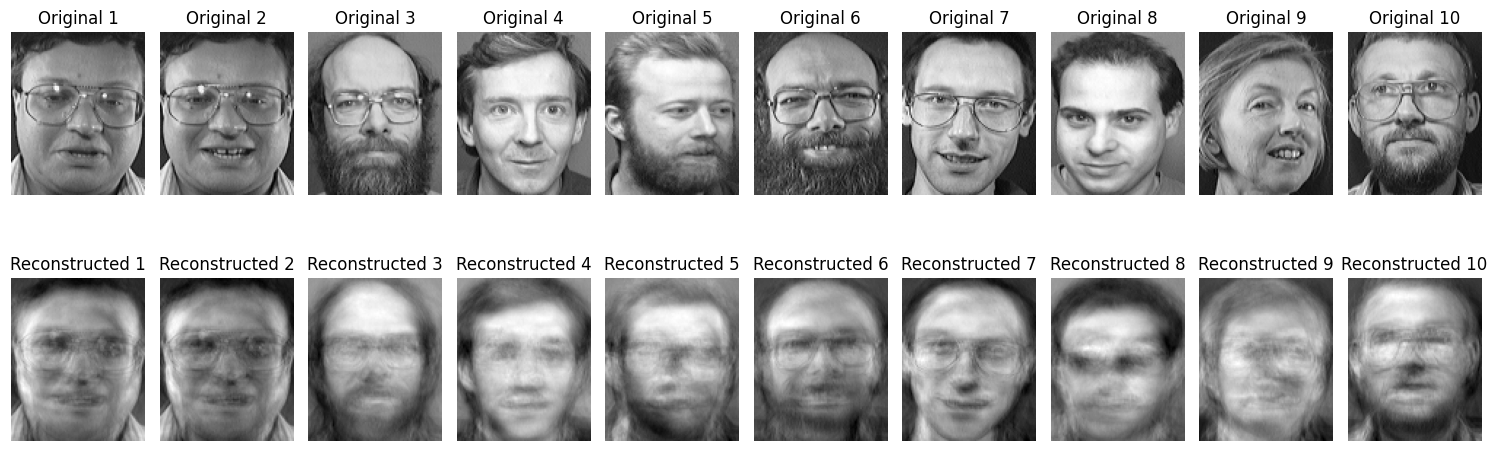




-------------------------------The number of PC  = 50-----------------------------------
-------------------------------With information preserved = 81.96 % -------------------------------


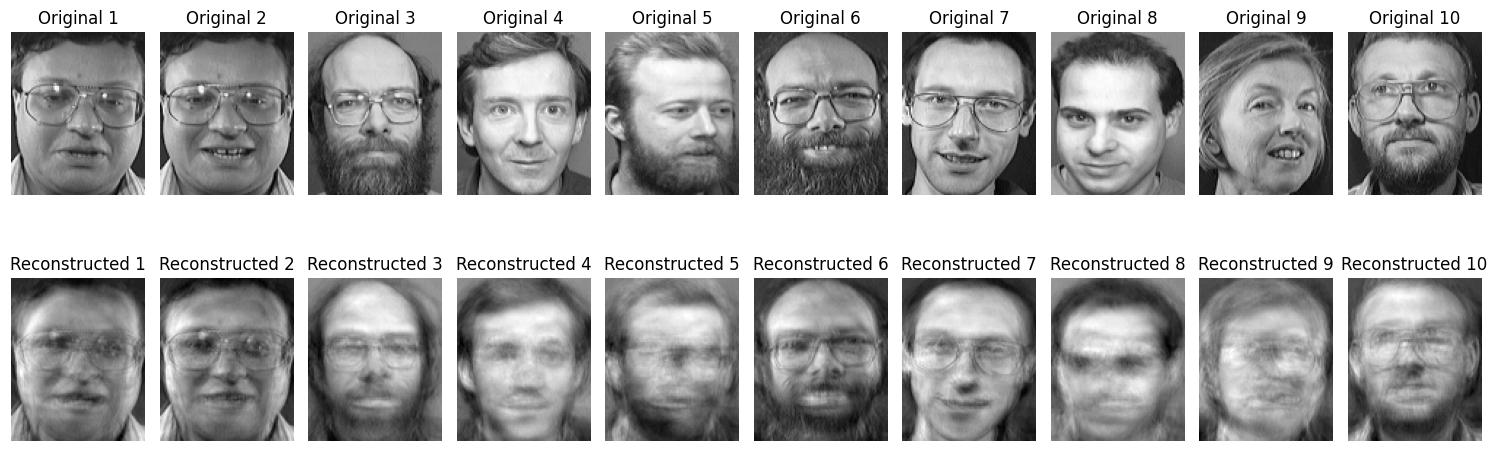




-------------------------------The number of PC  = 70-----------------------------------
-------------------------------With information preserved = 85.769 % -------------------------------


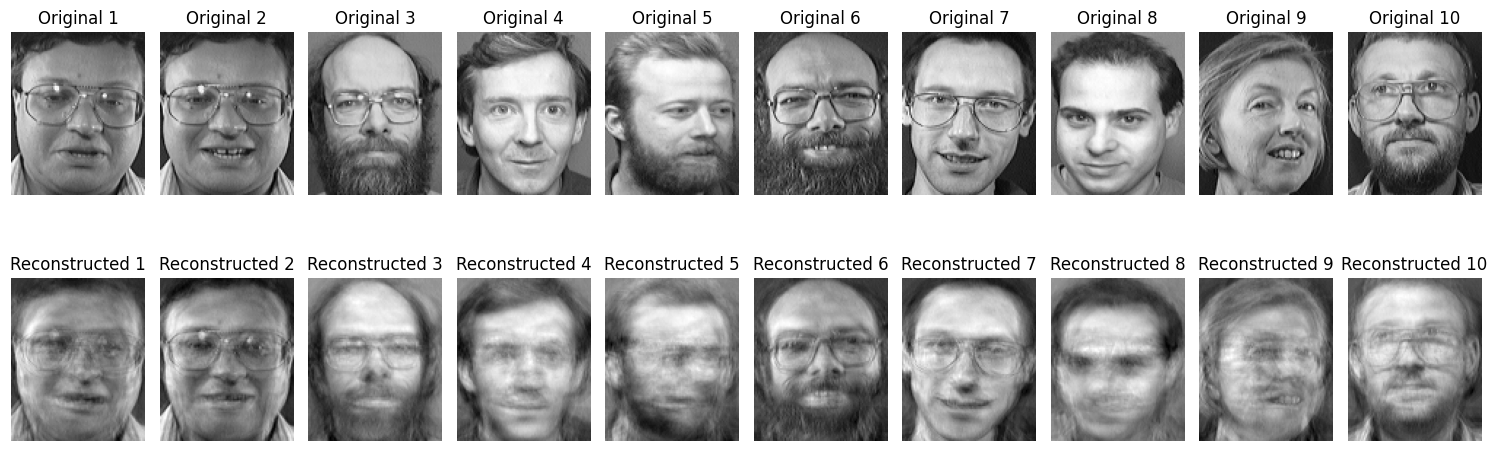




-------------------------------The number of PC  = 100-----------------------------------
-------------------------------With information preserved = 89.546 % -------------------------------


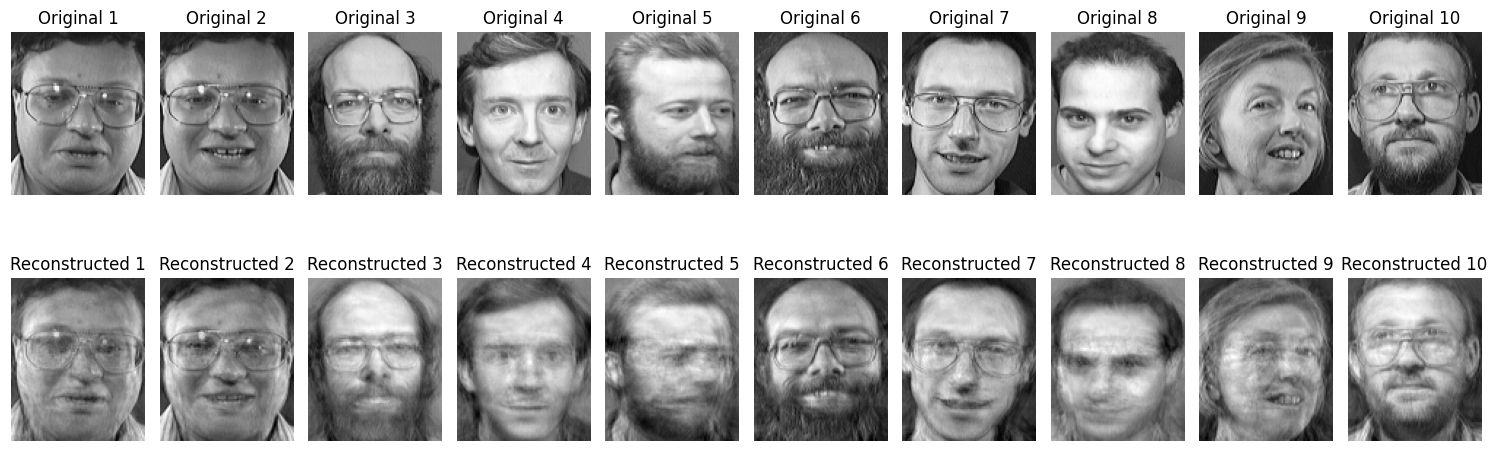




-------------------------------The number of PC  = 150-----------------------------------
-------------------------------With information preserved = 93.508 % -------------------------------


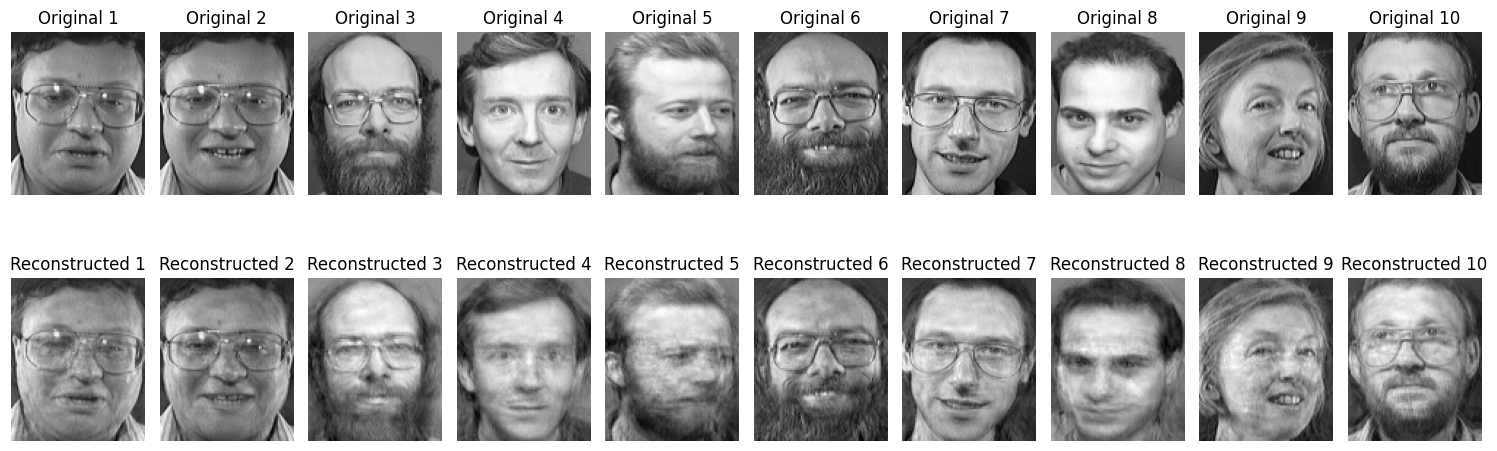




-------------------------------The number of PC  = 200-----------------------------------
-------------------------------With information preserved = 96.084 % -------------------------------


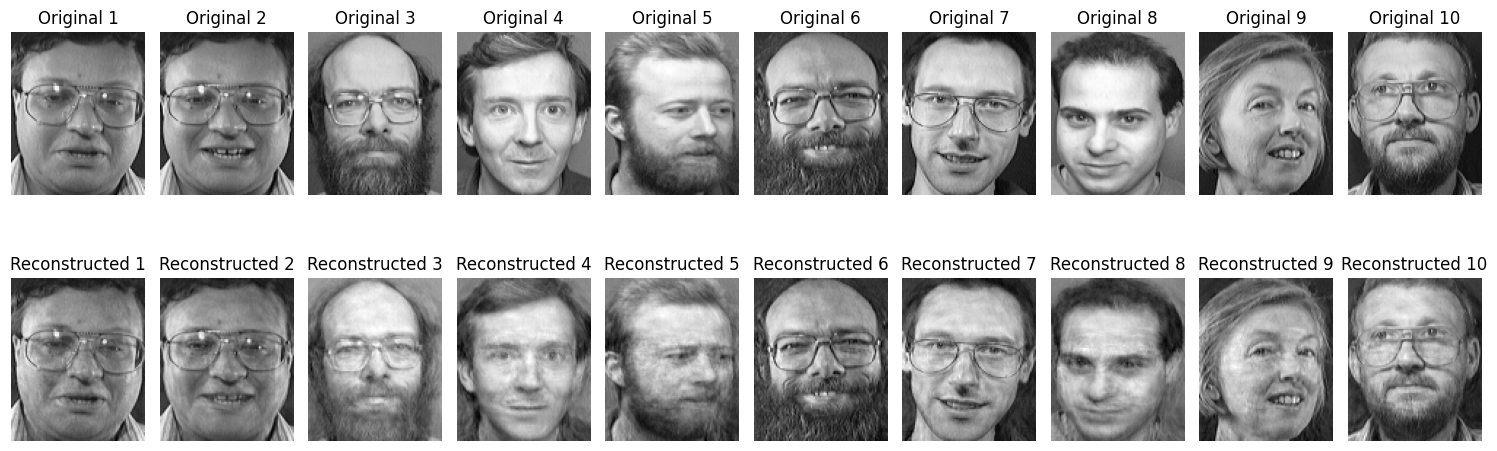




-------------------------------The number of PC  = 250-----------------------------------
-------------------------------With information preserved = 97.853 % -------------------------------


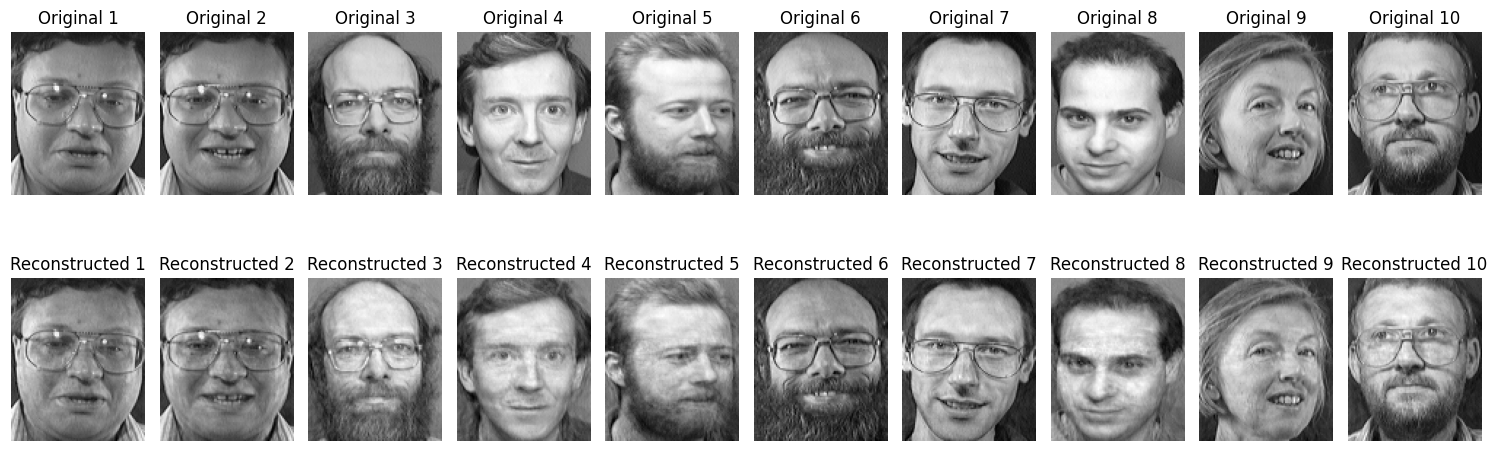




-------------------------------The number of PC  = 300-----------------------------------
-------------------------------With information preserved = 99.086 % -------------------------------


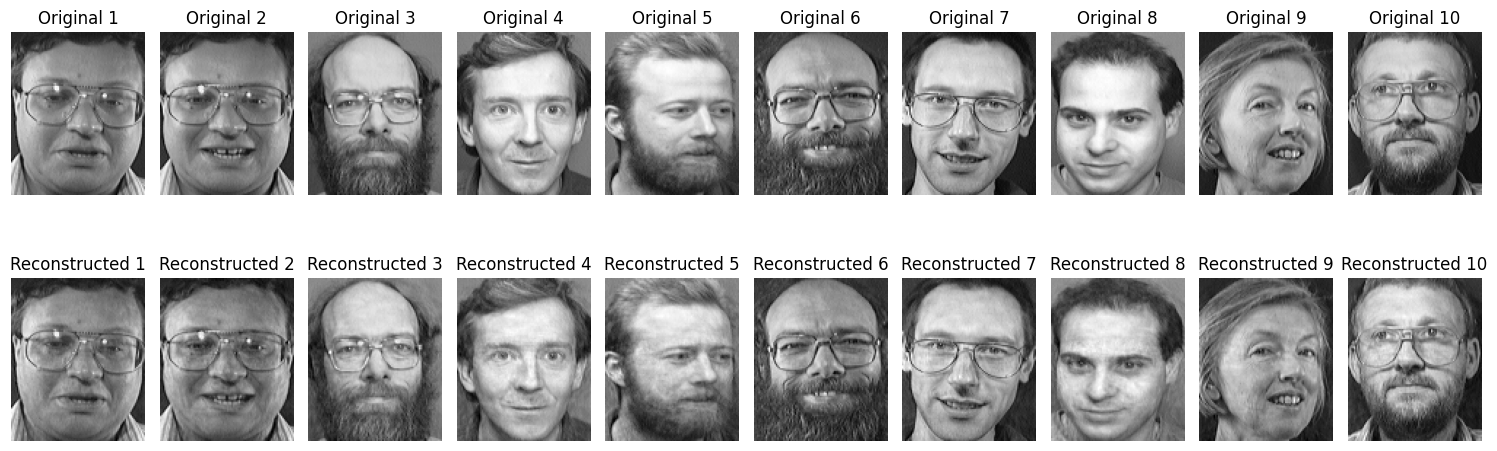




-------------------------------The number of PC  = 350-----------------------------------
-------------------------------With information preserved = 99.908 % -------------------------------


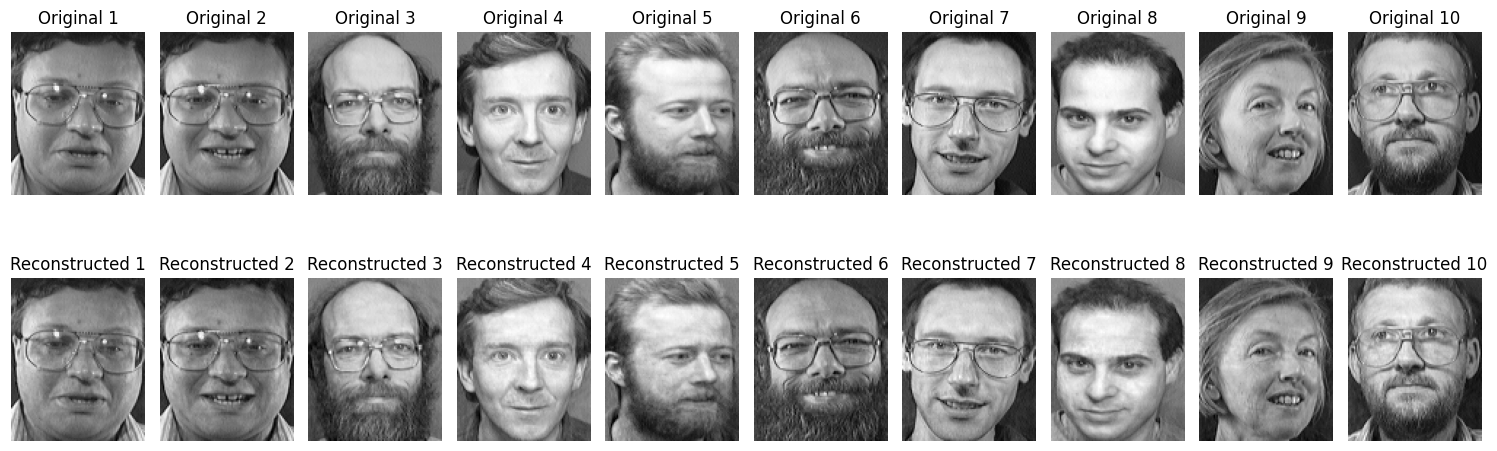




-------------------------------The number of PC  = 400-----------------------------------
-------------------------------With information preserved = 100.0 % -------------------------------


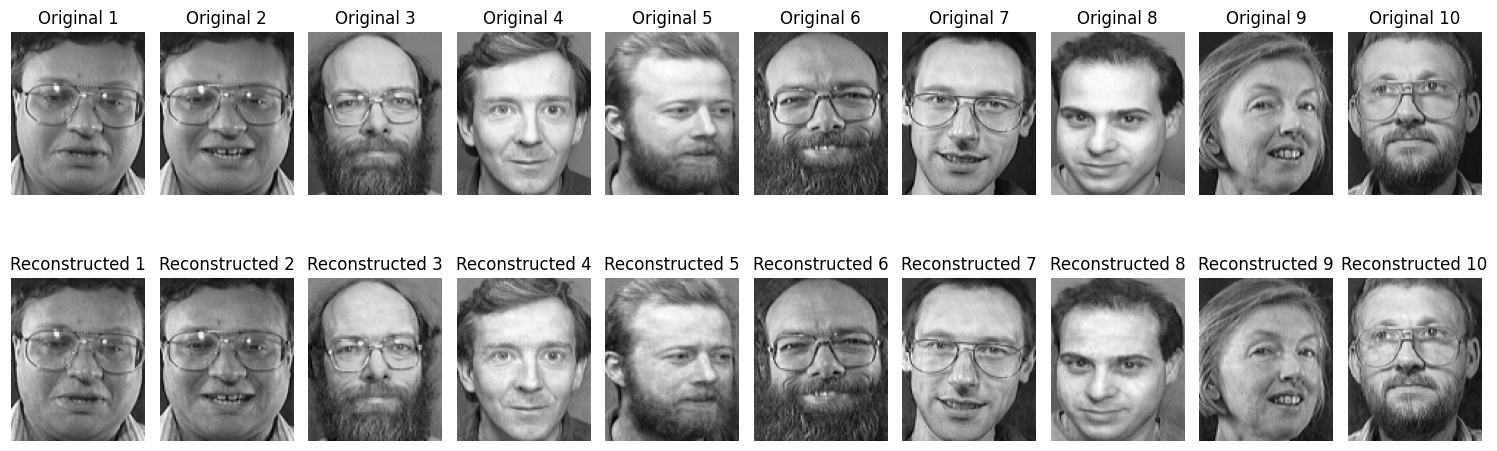




-------------------------------The number of PC  = 450-----------------------------------
-------------------------------With information preserved = 100.0 % -------------------------------


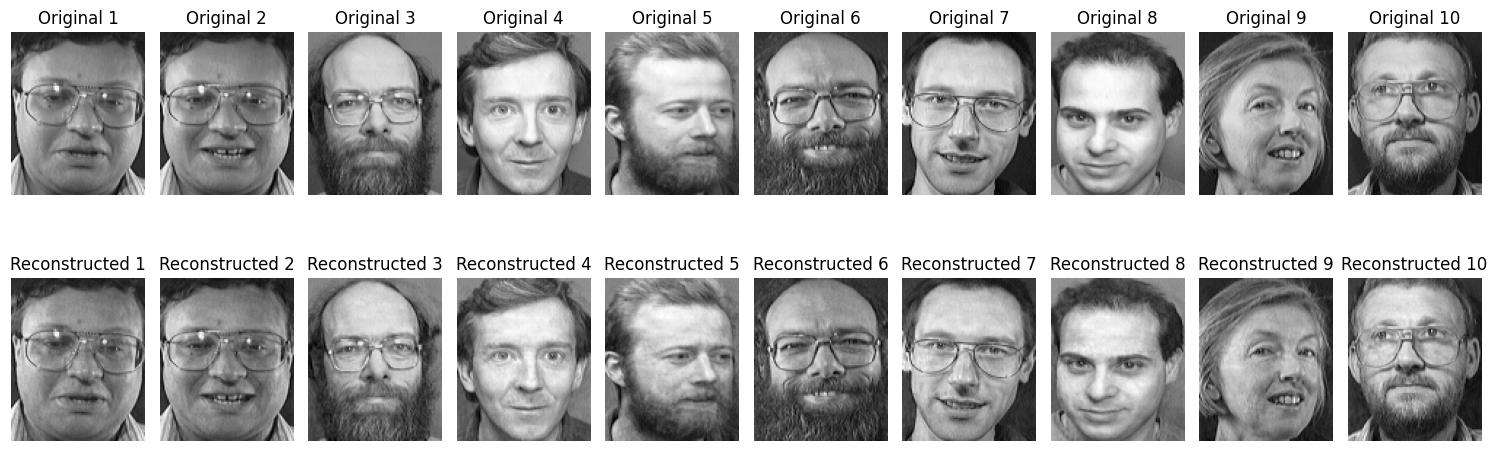




-------------------------------The number of PC  = 500-----------------------------------
-------------------------------With information preserved = 100.0 % -------------------------------


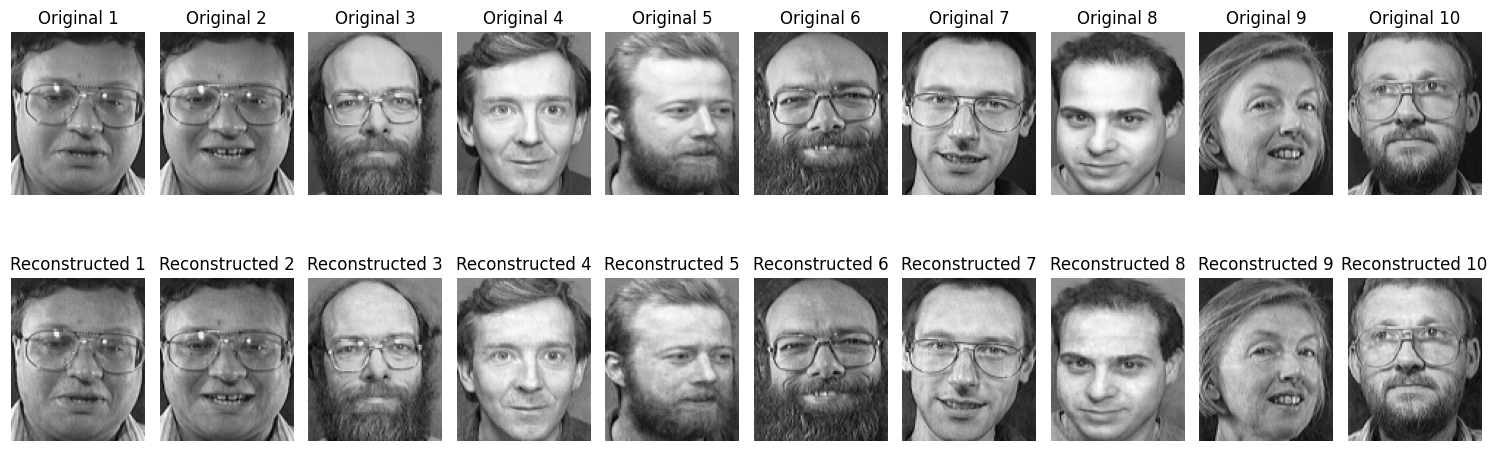

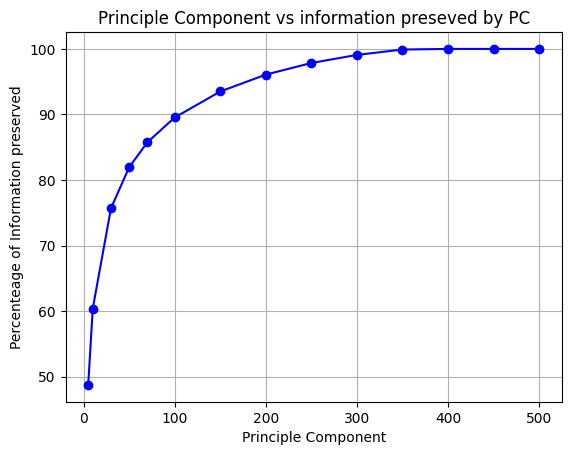

In [12]:
displayNfactors()

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [13]:
print(f'Train Size =  {len(trainFaces)} \nTest size = {len(testFaces)}')

Train Size =  360 
Test size = 40


In [14]:
'''
    Returning the norm distance between 2 face by np LA function
'''
def calculate_norm_distance(face1, face2):
    return np.linalg.norm(face1 - face2)

In [15]:
def getClass(test_image, eigenvectors, mean_eigen_face, X_train, y_train):

    '''
        1. calculating the distance of test image to all train image and store in data structure
        2. finding the most similar image by   finding image that have minimum norm distance
        3. take minimum norm image class as predicted image
        4. finding the which image is that have minimum norm distace
    '''
    
    distances = [calculate_norm_distance(test_image, train_image) for train_image in X_train]
    
    min_distance_index = np.argmin(distances)
    
    predicted_class = y_train[min_distance_index]
    
    nearest_neighbor_image = X_train[min_distance_index]
    error_value = distances[min_distance_index]
    
    return nearest_neighbor_image, error_value, predicted_class

In [16]:
'''
    projecting dataset to particular eigenvector

    perform the dimension reduction 
    and return D' reduce dimension dataset
'''

def get_projections(dataset, eigen_vector):
    projected_data = np.dot(dataset, eigen_vector)
    return projected_data

In [17]:
'''
    1. calculating the distance of test image to all train image and store in data structure
    2. finding the most similar image by   finding image that have minimum norm distance
    3. take minimum norm image class as predicted image and return it
'''

def get_prediction(test_image , X_train, y_train):

    distances = [calculate_norm_distance(test_image, train_image) for train_image in X_train]
    
    min_distance_index = np.argmin(distances)
    
    predicted_class = y_train[min_distance_index]
    
    return predicted_class

In [18]:
'''
    - recontructing the face 
    - return  the recontrcuted face
    
    - perform the D' dimension to D dimention operation
'''

def reconstruct_faces(projections, eigenfaces, mean_face):
    reconstructed = np.dot(projections, eigenfaces.T) + mean_face
    reconstructed = reconstructed.reshape(-1, 112, 92)
    return reconstructed

In [19]:
'''
    - Flattern the dataset
    - substracting the mean of the dataset
'''


trainFaces = trainFaces.reshape(-1, image_width*image_height).astype('float32')
testFaces = testFaces.reshape(-1, image_width*image_height).astype('float32')

mean_eigen_face = np.mean(trainFaces, axis=0)

trainFaces = trainFaces - mean_eigen_face
testFaces = testFaces - mean_eigen_face

In [20]:
'''
    - taking the serveral the number component 
    - perform the dimension reduction
    - prediction and finding the accuracy and mse and long(mse)
'''


components = [i for i in range(1,600,5)]
mse_list = []
accuracies= []
log_mse = []

for comp in components:

    top_eigen_faces = eigen_faces[:, :comp]

    train_projection = get_projections(trainFaces , top_eigen_faces)
    test_projection = get_projections(testFaces , top_eigen_faces)

    predictoions = [ get_prediction(testprojection , train_projection , trainLabels )   for testprojection in test_projection]
    
    accuracy = accuracy_score(testLabels, predictoions)
    
    reconstructed_faces = reconstruct_faces(test_projection, top_eigen_faces, mean_eigen_face)
    reconstructed_faces = reconstructed_faces.reshape(-1, image_width*image_height).astype('float32')
  
    # print(testFaces.shape , reconstructed_faces.shape)
  
    mse = np.mean(np.mean((testFaces - reconstructed_faces) ** 2))   
  

    accuracies.append(accuracy)
    mse_list.append(mse)
    log_mse.append(np.log(mse))

Iterate through all the images in the test data and test the accuracy by taking different number of components

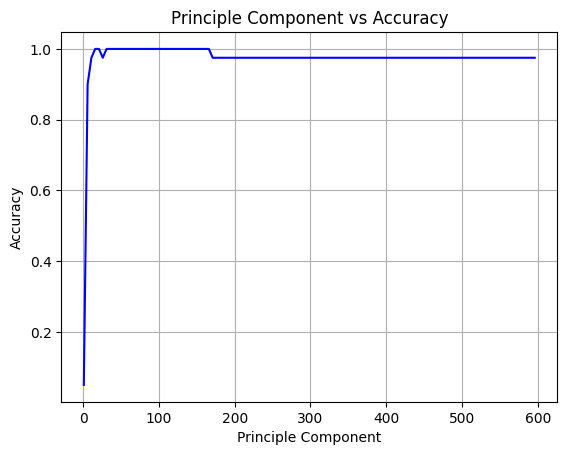

In [21]:
plt.plot(components, accuracies, color='b')
plt.title('Principle Component vs Accuracy')
plt.xlabel('Principle Component')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Mean Square Error

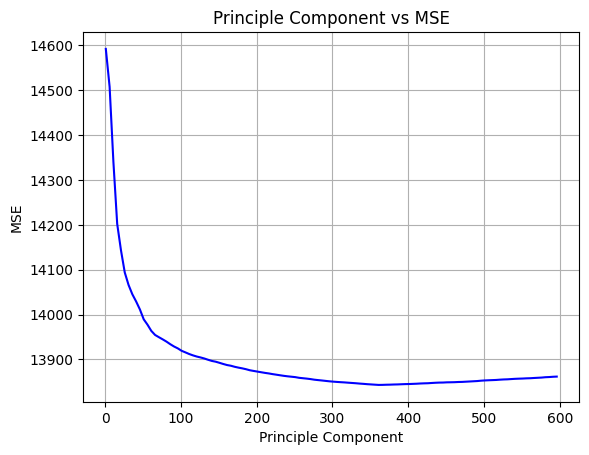

In [22]:
plt.plot(components, mse_list, color='b')
plt.title('Principle Component vs MSE')
plt.xlabel('Principle Component')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

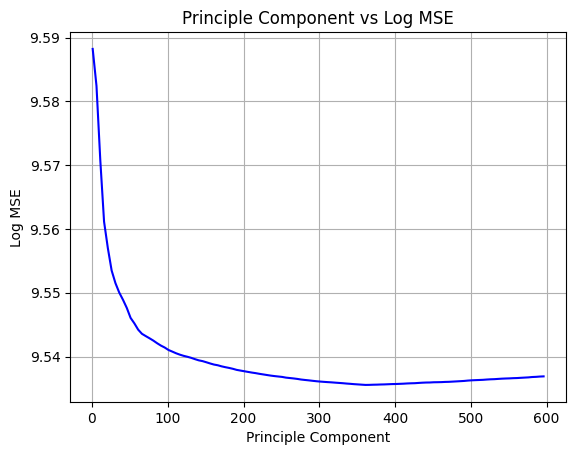

In [23]:
plt.plot(components, log_mse, color='b')
plt.title('Principle Component vs Log MSE')
plt.xlabel('Principle Component')
plt.ylabel('Log MSE')
plt.grid(True)
plt.show()